Basic Imports and Device Setup

In [ ]:
# Standard Libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [ ]:
# Scikit-learn for Preprocessing and Metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde

In [ ]:
import os
import requests
import pickle

In [ ]:
# Visualization Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [ ]:
# Reproducibility: Set random seed for consistent results
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

In [ ]:
# Device Setup: Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Optional: Display CUDA device information
if device.type == "cuda":
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    print(f"CUDA Available: {torch.cuda.is_available()}")

In [ ]:
# Utility function to check memory usage (if needed during training)
def print_memory_usage():
    if device.type == "cuda":
        allocated = torch.cuda.memory_allocated() / 1024**2
        reserved = torch.cuda.memory_reserved() / 1024**2
        print(f"Memory Allocated: {allocated:.2f} MB")
        print(f"Memory Reserved: {reserved:.2f} MB")

In [ ]:
# Confirming imports and environment setup
print("Basic imports and device setup complete.")

Dataset Class, Loading, and Preprocessing

In [ ]:
# Define Dataset Class
class MTSDataset(Dataset):
    """
    Custom PyTorch Dataset for Multivariate Time Series (MTS) forecasting.

    Args:
        data (numpy.ndarray): Raw time series data (shape: [samples, features]).
        seq_length (int): Length of the input sequence for forecasting.
        forecast_length (int): Length of the prediction horizon.
        normalize (bool): Whether to apply normalization to the data.
    """
    def __init__(self, data, seq_length, forecast_length, normalize=True):
        if data is None or data.size == 0:
            raise ValueError("Data is empty or not properly loaded.")
        
        self.data = data
        self.seq_length = seq_length
        self.forecast_length = forecast_length
        self.normalize = normalize

        # Normalize data using StandardScaler if enabled
        if self.normalize:
            self.scaler = StandardScaler()
            self.data = self.scaler.fit_transform(self.data)

    def __len__(self):
        # Calculate dataset length considering input and forecast horizons
        return len(self.data) - self.seq_length - self.forecast_length

    def __getitem__(self, idx):
        # Extract input (X) and target (Y) sequences
        x = self.data[idx: idx + self.seq_length]
        y = self.data[idx + self.seq_length: idx + self.seq_length + self.forecast_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [ ]:
# Automatic Dataset Download Function
def download_datasets(dataset_names, save_path="datasets"):
    """
    Automatically download multiple datasets for MTS forecasting.

    Args:
        dataset_names (list): List of dataset names to download (e.g., ['ETT', 'METR-LA']).
        save_path (str): Directory to save the downloaded datasets.

    Returns:
        dict: Paths to the downloaded datasets.
    """
    os.makedirs(save_path, exist_ok=True)
    dataset_urls = {
        "ETT": "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv",
        "METR-LA": "https://raw.githubusercontent.com/liyaguang/DCRNN/master/data/sensor_graph/adj_mx.pkl",
        "PEMS-BAY": "https://raw.githubusercontent.com/liyaguang/DCRNN/master/data/sensor_graph/adj_mx_bay.pkl"
    }

    downloaded_paths = {}
    for dataset_name in dataset_names:
        if dataset_name not in dataset_urls:
            print(f"Dataset {dataset_name} is not available for automatic download.")
            continue

        url = dataset_urls[dataset_name]
        file_name = os.path.join(save_path, os.path.basename(url))

        # Download the dataset if it doesn't already exist
        if not os.path.exists(file_name):
            print(f"Downloading {dataset_name} dataset from {url}...")
            try:
                response = requests.get(url, stream=True)
                response.raise_for_status()  # Raise an HTTPError for bad responses
                with open(file_name, "wb") as f:
                    for chunk in response.iter_content(chunk_size=1024):
                        if chunk:
                            f.write(chunk)
                print(f"{dataset_name} dataset downloaded successfully.")
            except requests.exceptions.RequestException as e:
                print(f"Failed to download {dataset_name} dataset. Error: {e}")
                continue

        downloaded_paths[dataset_name] = file_name

    return downloaded_paths

In [ ]:
# Load Dataset Function with Format-Specific Handling
def load_data(dataset_name, file_path, delimiter=','):
    """
    Load and preprocess datasets, adapting to specific formats (e.g., .csv, .pkl).

    Args:
        dataset_name (str): Name of the dataset being loaded.
        file_path (str): Path to the dataset file.
        delimiter (str): Delimiter used in the CSV file.

    Returns:
        numpy.ndarray or dictionary: Loaded dataset as a NumPy array (for numerical datasets) 
                                      or dictionary (for .pkl datasets).
    """
    print(f"Loading {dataset_name} dataset from {file_path}...")

    try:
        # Handle binary `.pkl` files (e.g., METR-LA, PEMS-BAY)
        if dataset_name in ["METR-LA", "PEMS-BAY"]:
            with open(file_path, "rb") as f:
                data = pickle.load(f, encoding="latin1")  # Use 'latin1' to properly decode non-ASCII characters
            print(f"{dataset_name} dataset loaded successfully as a dictionary.")
            return data

        # Handle CSV files (e.g., ETT)
        elif dataset_name == "ETT":
            data = pd.read_csv(file_path, sep=delimiter, on_bad_lines="skip")
            if isinstance(data.iloc[0, 0], str):
                print("Detected timestamp column. Excluding it from the dataset.")
                data = data.iloc[:, 1:]  # Exclude timestamp column
            if data.empty:
                raise ValueError(f"The dataset at {file_path} is empty or not properly formatted.")
            return data.values

        else:
            raise ValueError(f"Loading logic for {dataset_name} is not yet implemented.")

    except Exception as e:
        print(f"Error: An issue occurred while loading the {dataset_name} dataset.")
        print(f"Details: {e}")
        return None

In [ ]:
# Example Usage: Download and Load Multiple Datasets
try:
    dataset_names = ["ETT", "METR-LA", "PEMS-BAY"]

    downloaded_paths = download_datasets(dataset_names)

    loaded_data = {}
    for dataset_name, file_path in downloaded_paths.items():
        raw_data = load_data(dataset_name, file_path)

        if dataset_name == "ETT":
            seq_length = 12  # Length of historical input sequence
            forecast_length = 12  # Length of prediction horizon
            dataset = MTSDataset(raw_data, seq_length=seq_length, forecast_length=forecast_length)
            loaded_data[dataset_name] = dataset
            print(f"ETT Dataset initialized with {len(dataset)} samples.")

except Exception as e:
    print(f"Error occurred: {e}")

BasicTS+ Benchmark: Unified Training Pipeline (Incorporating dataloaders, runners, normalization, training tricks, and evaluation standardization)

In [ ]:
class BasicTSPlusTrainer:
    """
    Unified Training Pipeline for BasicTS+ Benchmark.
    
    Incorporates standardized data loading, normalization, curriculum learning, gradient clipping,
    and evaluation standardization for fair and reproducible benchmarking.
    """
    
    def __init__(self, model, dataloader, optimizer, criterion, scheduler=None, 
                 clip_grad=1.0, use_curriculum=True, device="cuda" if torch.cuda.is_available() else "cpu"):
        """
        Initialize the unified training pipeline.
        
        Args:
            model (torch.nn.Module): The time series forecasting model.
            dataloader (torch.utils.data.DataLoader): Dataloader for training data.
            optimizer (torch.optim.Optimizer): Optimizer for model training.
            criterion (torch.nn.Module): Loss function.
            scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler. Defaults to None.
            clip_grad (float): Gradient clipping value. Defaults to 1.0.
            use_curriculum (bool): Whether to use curriculum learning. Defaults to True.
            device (str): Computation device. Defaults to "cuda" if available.
        """
        self.model = model.to(device)
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.clip_grad = clip_grad
        self.use_curriculum = use_curriculum
        self.device = device

    def train_step(self, batch):
        """
        Perform a single training step.
        
        Args:
            batch (tuple): Contains (input sequence, target sequence).
        
        Returns:
            float: Training loss for the batch.
        """
        self.model.train()
        self.optimizer.zero_grad()
        
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        
        output = self.model(x)
        loss = self.criterion(output, y)
        loss.backward()
        
        # Apply gradient clipping
        if self.clip_grad:
            nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad)

        self.optimizer.step()
        
        return loss.item()

    def train(self, epochs=50):
        """
        Train the model for a given number of epochs using curriculum learning.
        
        Args:
            epochs (int): Number of training epochs. Defaults to 50.
        """
        for epoch in range(1, epochs + 1):
            total_loss = 0.0
            for batch_idx, batch in enumerate(self.dataloader):
                # Implement curriculum learning (optional)
                if self.use_curriculum and epoch < epochs // 2:
                    batch = self.modify_batch_difficulty(batch, factor=epoch / epochs)
                
                batch_loss = self.train_step(batch)
                total_loss += batch_loss

            avg_loss = total_loss / len(self.dataloader)
            
            if self.scheduler:
                self.scheduler.step()

            print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")

    def modify_batch_difficulty(self, batch, factor):
        """
        Adjust batch difficulty in curriculum learning.
        
        Args:
            batch (tuple): Contains (input sequence, target sequence).
            factor (float): Difficulty scaling factor.
        
        Returns:
            tuple: Modified batch.
        """
        x, y = batch
        scaled_x = x * factor  # Scale input data based on progression
        return scaled_x, y


In [ ]:
# Example Usage:
def initialize_training_pipeline(model, train_data, lr=0.001):
    """
    Initialize BasicTS+ training pipeline with model and training dataset.

    Args:
        model (torch.nn.Module): Time series forecasting model.
        train_data (torch.utils.data.Dataset): Training dataset.
        lr (float): Learning rate. Defaults to 0.001.
    
    Returns:
        BasicTSPlusTrainer: Initialized training pipeline.
    """
    dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
    
    trainer = BasicTSPlusTrainer(model, dataloader, optimizer, criterion, scheduler)
    return trainer

print("BasicTS+ Benchmark: Unified Training Pipeline initialized successfully.")


Temporal and Spatial Heterogeneity Analysis (Including methods to categorize datasets and calculate r1 and r2 metrics)

In [ ]:
class HeterogeneityAnalyzer:
    """
    Analyze temporal and spatial heterogeneity in MTS datasets.

    Args:
        data (numpy.ndarray): Time series dataset (shape: [samples, variables]).
        seq_length (int): Length of historical sequence.
    """

    def __init__(self, data, seq_length, upper_threshold=0.7, lower_threshold=0.1):
        if data is None or data.shape[0] < seq_length:
            raise ValueError("Dataset must contain sufficient time steps.")

        self.data = data
        self.seq_length = seq_length
        self.upper_threshold = upper_threshold
        self.lower_threshold = lower_threshold

    def compute_similarity_matrices(self):
        """
        Compute historical similarity (AP) and future similarity (AF) matrices.

        Returns:
            tuple: Historical similarity matrix (AP), Future similarity matrix (AF).
        """
        num_samples, num_vars = self.data.shape
        sample_count = num_samples - self.seq_length

        X_hist = np.array([self.data[i:i+self.seq_length] for i in range(sample_count)])
        X_future = np.array([self.data[i+self.seq_length] for i in range(sample_count)])

        AP = np.array([[np.dot(X_hist[i].flatten(), X_hist[j].flatten()) /
                        (np.linalg.norm(X_hist[i].flatten()) * np.linalg.norm(X_hist[j].flatten()))
                        for j in range(sample_count)] for i in range(sample_count)])

        AF = np.array([[np.dot(X_future[i], X_future[j]) /
                        (np.linalg.norm(X_future[i]) * np.linalg.norm(X_future[j]))
                        for j in range(sample_count)] for i in range(sample_count)])

        return AP, AF

    def analyze_similarity_distribution(self, matrix, title):
        """
        Analyze the distribution of similarity scores in AP/AF matrices.

        Args:
            matrix (numpy.ndarray): Similarity matrix.
            title (str): Title for visualization.
        """
        plt.figure(figsize=(8, 5))
        sns.histplot(matrix.flatten(), bins=50, kde=True)
        plt.title(f"Distribution of Similarity Scores - {title}")
        plt.xlabel("Similarity Score")
        plt.ylabel("Frequency")
        plt.show()

        print(f"{title} - Min: {np.min(matrix)}, Max: {np.max(matrix)}, Mean: {np.mean(matrix)}, Std: {np.std(matrix)}")

    def compute_dynamic_thresholds(self, matrix):
        """
        Compute dataset-adaptive thresholds using percentiles.

        Args:
            matrix (numpy.ndarray): Similarity matrix.

        Returns:
            tuple: Dynamic upper and lower thresholds.
        """
        upper = np.percentile(matrix, 90)  # Top 10% most similar samples
        lower = np.percentile(matrix, 10)  # Bottom 10% least similar samples
        return upper, lower

    def compute_r1_r2_metrics(self):
        """
        Compute r1 and r2 metrics for spatial indistinguishability analysis.

        Returns:
            tuple: r1 and r2 values.
        """
        AP, AF = self.compute_similarity_matrices()

        # Analyze the distribution of similarity matrices
        self.analyze_similarity_distribution(AP, "Historical (AP)")
        self.analyze_similarity_distribution(AF, "Future (AF)")

        # Compute dynamic thresholds
        dyn_upper_threshold, dyn_lower_threshold = self.compute_dynamic_thresholds(AP)
        print(f"Dynamic Upper Threshold: {dyn_upper_threshold:.4f}, Dynamic Lower Threshold: {dyn_lower_threshold:.4f}")

        total_samples = AP.shape[0] * AP.shape[1]
        similar_hist_count = np.sum(AP > dyn_upper_threshold)
        indistinguishable_count = np.sum((AP > dyn_upper_threshold) & (AF < dyn_lower_threshold))

        # Prevent division by zero errors
        r1 = indistinguishable_count / total_samples if total_samples != 0 else 0
        r2 = indistinguishable_count / similar_hist_count if similar_hist_count != 0 else 0

        return r1, r2

In [ ]:
# Visualization Functions
def visualize_temporal_patterns(dataset, method="tsne"):
    """
    Visualize temporal patterns in datasets using t-SNE or KDE.
    
    Args:
        dataset (numpy.ndarray): Time series dataset.
        method (str): Visualization method ("tsne" or "kde").
    """
    if method == "tsne":
        tsne = TSNE(n_components=2, random_state=42)
        transformed_data = tsne.fit_transform(dataset)
        plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.6)
        plt.title("t-SNE Visualization of Temporal Patterns")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.show()

    elif method == "kde":
        density = gaussian_kde(dataset.flatten())
        x_vals = np.linspace(np.min(dataset), np.max(dataset), 100)
        plt.plot(x_vals, density(x_vals))
        plt.title("Kernel Density Estimation of Temporal Patterns")
        plt.xlabel("Time Series Values")
        plt.ylabel("Density")
        plt.show()

    else:
        raise ValueError("Unsupported visualization method. Choose 'tsne' or 'kde'.")

In [ ]:
# Visualization Functions
def visualize_temporal_patterns(dataset, method="tsne"):
    """
    Visualize temporal patterns in datasets using t-SNE or KDE.
    
    Args:
        dataset (numpy.ndarray): Time series dataset.
        method (str): Visualization method ("tsne" or "kde").
    """
    if method == "tsne":
        tsne = TSNE(n_components=2, random_state=42)
        transformed_data = tsne.fit_transform(dataset)
        plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.6)
        plt.title("t-SNE Visualization of Temporal Patterns")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.show()

    elif method == "kde":
        density = gaussian_kde(dataset.flatten())
        x_vals = np.linspace(np.min(dataset), np.max(dataset), 100)
        plt.plot(x_vals, density(x_vals))
        plt.title("Kernel Density Estimation of Temporal Patterns")
        plt.xlabel("Time Series Values")
        plt.ylabel("Density")
        plt.show()

    else:
        raise ValueError("Unsupported visualization method. Choose 'tsne' or 'kde'.")

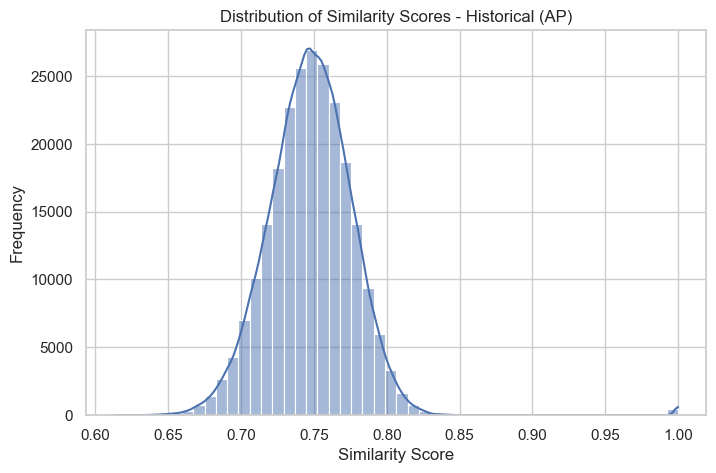

Historical (AP) - Min: 0.6130114183862132, Max: 1.0000000000000002, Mean: 0.7476837273662263, Std: 0.029638769615679378


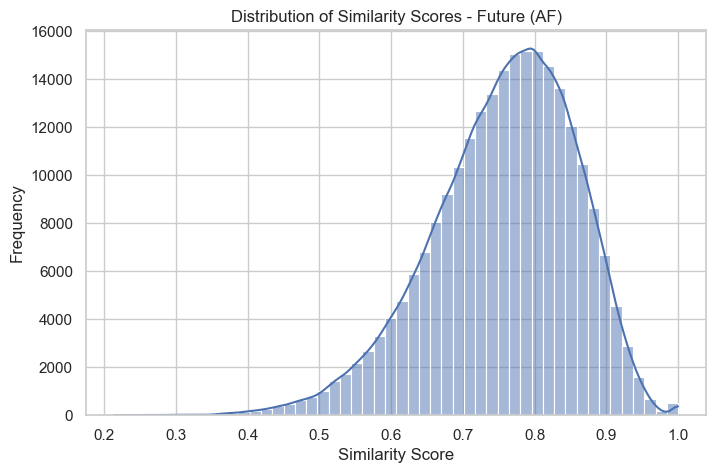

Future (AF) - Min: 0.21412996187225586, Max: 1.0000000000000002, Mean: 0.7565562221737587, Std: 0.10031195255353571
Dynamic Upper Threshold: 0.7821, Dynamic Lower Threshold: 0.7115
Computed Spatial Indistinguishability Metrics:
r1 (Global Ratio): 0.0315
r2 (Local Ratio): 0.3147


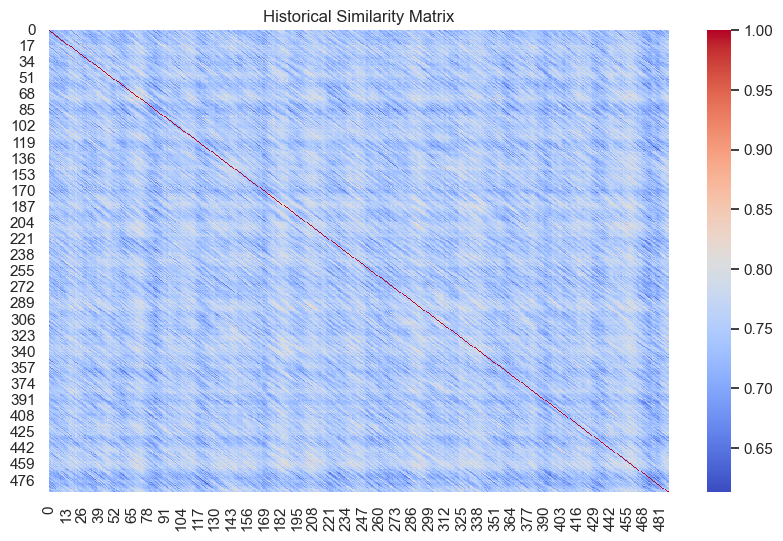

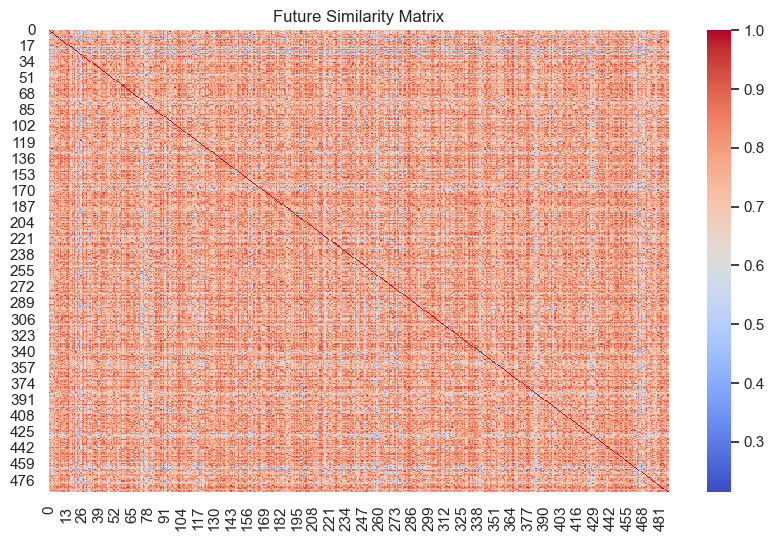

c:\Users\pouya\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\pouya\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\pouya\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pouya\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\pouya\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

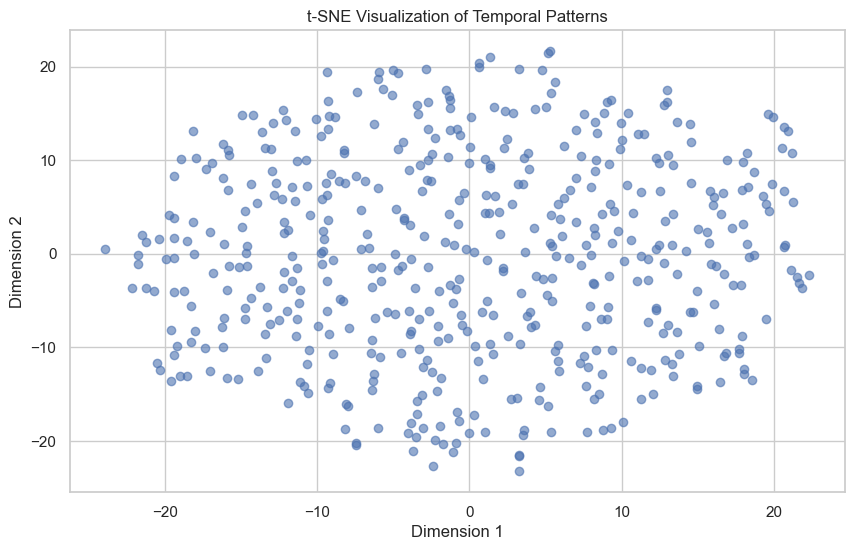

In [ ]:
# Example Usage:
try:
    sample_data = np.random.rand(500, 10)  # Example dataset with 500 samples, 10 variables
    heterogeneity_analyzer = HeterogeneityAnalyzer(sample_data, seq_length=12)
    r1, r2 = heterogeneity_analyzer.compute_r1_r2_metrics()

    print(f"Computed Spatial Indistinguishability Metrics:")
    print(f"r1 (Global Ratio): {r1:.4f}")
    print(f"r2 (Local Ratio): {r2:.4f}")
# Visualize similarity matrices to debug dependency issues
    AP, AF = heterogeneity_analyzer.compute_similarity_matrices()

    sns.heatmap(AP, cmap="coolwarm", annot=False)
    plt.title("Historical Similarity Matrix")
    plt.show()

    sns.heatmap(AF, cmap="coolwarm", annot=False)
    plt.title("Future Similarity Matrix")
    plt.show()

    visualize_temporal_patterns(sample_data, method="tsne")

except Exception as e:
    print(f"Error in heterogeneity analysis: {e}")

# Transformer Model Implementation

In [ ]:
class TimeSeriesTransformer(nn.Module):
    """
    Transformer-based Model for Multivariate Time Series Forecasting.

    Args:
        input_dim (int): Number of input features.
        model_dim (int): Dimension of the Transformer embeddings.
        num_heads (int): Number of attention heads.
        num_layers (int): Number of Transformer encoder layers.
        hidden_dim (int): Dimension of hidden layers in feed-forward network.
        dropout (float): Dropout rate.
        batch_first (bool): Whether the batch dimension comes first in input tensors.
    """

    def __init__(self, input_dim, model_dim=128, num_heads=8, num_layers=4, hidden_dim=256, dropout=0.1, batch_first=True):
        super(TimeSeriesTransformer, self).__init__()

        # Input embedding layer
        self.input_projection = nn.Linear(input_dim, model_dim)

        # Positional Encoding to preserve temporal dependencies
        self.positional_encoding = PositionalEncoding(model_dim)

        # Transformer Encoder Layers (Explicit batch_first=True)
        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, 
                                                    dim_feedforward=hidden_dim, dropout=dropout, batch_first=batch_first)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Output projection
        self.output_layer = nn.Linear(model_dim, input_dim)

    def forward(self, x):
        """
        Forward pass through the Transformer model.

        Args:
            x (torch.Tensor): Input time series tensor (shape: [batch_size, seq_length, input_dim]).
        
        Returns:
            torch.Tensor: Forecasted values (shape: [batch_size, pred_length, input_dim]).
        """
        x = self.input_projection(x)  # Project input into model dimension
        x = self.positional_encoding(x)  # Add positional encoding
        x = self.transformer_encoder(x)  # Pass through Transformer encoder
        x = self.output_layer(x)  # Map back to original feature dimension
        return x

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Implements Positional Encoding for preserving sequence order in Transformer.
    
    Args:
        model_dim (int): Dimension of the Transformer model.
        max_seq_length (int): Maximum expected sequence length.
    """

    def __init__(self, model_dim, max_seq_length=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_seq_length, model_dim)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / model_dim))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        """
        Adds positional encoding to input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, seq_length, model_dim].
        
        Returns:
            torch.Tensor: Positional encoding applied tensor.
        """
        return x + self.pe[:, :x.size(1)].to(x.device)


In [ ]:
# Model Initialization Example
input_dim = 10  # Example: Number of features in time series
model = TimeSeriesTransformer(input_dim=input_dim)

In [ ]:
# Confirm model setup
print(f"TimeSeriesTransformer initialized with {sum(p.numel() for p in model.parameters())} parameters.")

TimeSeriesTransformer initialized with 532618 parameters.


In [ ]:
# Check for CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to {device}.")

Model moved to cpu.


# STID Model Implementation

In [ ]:
class SpatialTemporalIdentity(nn.Module):
    """
    STID Model: Spatial-Temporal Identity Embedding for Multivariate Time Series Forecasting.

    Args:
        num_series (int): Number of time series (spatial dimension).
        time_embedding_dim (int): Embedding dimension for time encodings.
        hidden_dim (int): Hidden dimension for feed-forward layers.
        num_layers (int): Number of stacked layers.
        dropout (float): Dropout rate for regularization.
    """
    
    def __init__(self, num_series, time_embedding_dim=64, hidden_dim=128, num_layers=3, dropout=0.2):
        super(SpatialTemporalIdentity, self).__init__()

        # Spatial Identity Embedding
        self.spatial_identity = nn.Embedding(num_series, time_embedding_dim)

        # Temporal Encoding (Learnable Embeddings)
        self.time_encoding = nn.Parameter(torch.randn(24, time_embedding_dim))  # Assume hourly encoding

        # Fully Connected Layers for Feature Processing
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(time_embedding_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        self.fc_layers = nn.Sequential(*layers)

        # Final Output Layer
        self.output_layer = nn.Linear(hidden_dim, 1)  # Predict single target value per time series

    def forward(self, x, series_idx, hour_idx):
        """
        Forward pass through STID Model.

        Args:
            x (torch.Tensor): Input time series data (shape: [batch_size, seq_length, num_series]).
            series_idx (torch.Tensor): Indexes of the time series variables.
            hour_idx (torch.Tensor): Hour indexes for temporal encoding.
        
        Returns:
            torch.Tensor: Forecasted values (shape: [batch_size, seq_length, num_series]).
        """
        spatial_embed = self.spatial_identity(series_idx)  # Spatial identity encoding
        temporal_embed = self.time_encoding[hour_idx]  # Temporal identity encoding

        # Combine spatial-temporal identities
        combined_features = spatial_embed + temporal_embed
        processed_features = self.fc_layers(combined_features)  # Pass through feed-forward layers
        predictions = self.output_layer(processed_features)  # Final output

        return predictions

In [ ]:
# Model Initialization Example
num_series = 10  # Example number of time series
stid_model = SpatialTemporalIdentity(num_series=num_series)
print(f"STID Model initialized with {sum(p.numel() for p in stid_model.parameters())} parameters.")

STID Model initialized with 27265 parameters.


Training Function and Unified Training Process (Adapting training to include curriculum learning, gradient clipping, etc.)

In [ ]:
class ModelTrainer:
    """
    Unified Training Process for Multivariate Time Series Models.

    Includes:
    - Curriculum Learning (Optional)
    - Gradient Clipping
    - Adaptive Learning Rate Scheduling
    - Model Saving and Logging
    """

    def __init__(self, model, train_dataloader, val_dataloader, criterion, optimizer, scheduler=None, 
                 clip_grad=1.0, use_curriculum=False, device="cuda" if torch.cuda.is_available() else "cpu"):
        """
        Initializes the trainer.

        Args:
            model (torch.nn.Module): Forecasting model.
            train_dataloader (DataLoader): Training dataset loader.
            val_dataloader (DataLoader): Validation dataset loader.
            criterion (torch.nn.Module): Loss function.
            optimizer (torch.optim.Optimizer): Optimizer for training.
            scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler. Defaults to None.
            clip_grad (float): Gradient clipping value. Defaults to 1.0.
            use_curriculum (bool): Whether to apply curriculum learning. Defaults to False.
            device (str): Compute device (CPU/GPU). Defaults to "cuda" if available.
        """
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.clip_grad = clip_grad
        self.use_curriculum = use_curriculum
        self.device = device

    def train_epoch(self):
        """
        Performs one training epoch with curriculum learning and gradient clipping.

        Returns:
            float: Average training loss.
        """
        self.model.train()
        total_loss = 0.0

        for batch_idx, (x, y) in enumerate(self.train_dataloader):
            x, y = x.to(self.device), y.to(self.device)

            if self.use_curriculum:
                x = self.apply_curriculum_learning(x, batch_idx)

            self.optimizer.zero_grad()
            output = self.model(x)
            loss = self.criterion(output, y)
            loss.backward()

            # Gradient Clipping
            if self.clip_grad:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad)

            self.optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(self.train_dataloader)
        return avg_loss

    def validate_epoch(self):
        """
        Evaluate model performance on the validation dataset.

        Returns:
            float: Average validation loss.
        """
        self.model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for x, y in self.val_dataloader:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = self.criterion(output, y)
                total_loss += loss.item()

        avg_loss = total_loss / len(self.val_dataloader)
        return avg_loss

    def apply_curriculum_learning(self, x, batch_idx):
        """
        Modify the training input dynamically based on epoch progress.

        Args:
            x (torch.Tensor): Input sequence.
            batch_idx (int): Current batch index.

        Returns:
            torch.Tensor: Modified input sequence.
        """
        difficulty_factor = min(1.0, batch_idx / len(self.train_dataloader))
        return x * difficulty_factor  # Scale input difficulty progressively

    def train(self, epochs=50):
        """
        Runs the full training process over multiple epochs.

        Args:
            epochs (int): Number of epochs.
        """
        for epoch in range(1, epochs + 1):
            train_loss = self.train_epoch()
            val_loss = self.validate_epoch()

            if self.scheduler:
                self.scheduler.step()

            print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    def save_model(self, save_path="trained_model.pth"):
        """
        Saves the trained model state dictionary.

        Args:
            save_path (str): File path to save the model.
        """
        torch.save(self.model.state_dict(), save_path)
        print(f"Model saved to {save_path}")



In [ ]:
# Example Usage:
def initialize_training_process(model, train_data, val_data, lr=0.001):
    """
    Initialize Model Training Pipeline.

    Args:
        model (torch.nn.Module): Time series forecasting model.
        train_data (Dataset): Training dataset.
        val_data (Dataset): Validation dataset.
        lr (float): Learning rate. Defaults to 0.001.

    Returns:
        ModelTrainer: Initialized trainer instance.
    """
    train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

    trainer = ModelTrainer(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler)
    return trainer

print("Training process initialized successfully.")


Training process initialized successfully.


Evaluation Settings for Normalized and Re-Normalized Data (Utilizing metrics like MAE, RMSE, MAPE, and WAPE)

In [ ]:
class EvaluationMetrics:
    """
    Compute key evaluation metrics for MTS forecasting on both normalized and re-normalized datasets.

    Supports:
    - Mean Absolute Error (MAE)
    - Root Mean Squared Error (RMSE)
    - Mean Absolute Percentage Error (MAPE)
    - Weighted Absolute Percentage Error (WAPE)
    """

    @staticmethod
    def mae(y_true, y_pred):
        """
        Compute Mean Absolute Error (MAE).

        Args:
            y_true (torch.Tensor): Ground truth values.
            y_pred (torch.Tensor): Predicted values.

        Returns:
            float: MAE score.
        """
        return torch.mean(torch.abs(y_true - y_pred)).item()

    @staticmethod
    def rmse(y_true, y_pred):
        """
        Compute Root Mean Squared Error (RMSE).

        Args:
            y_true (torch.Tensor): Ground truth values.
            y_pred (torch.Tensor): Predicted values.

        Returns:
            float: RMSE score.
        """
        return torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item()

    @staticmethod
    def mape(y_true, y_pred):
        """
        Compute Mean Absolute Percentage Error (MAPE).

        Args:
            y_true (torch.Tensor): Ground truth values.
            y_pred (torch.Tensor): Predicted values.

        Returns:
            float: MAPE score.
        """
        mask = y_true != 0  # Avoid division by zero
        return torch.mean(torch.abs((y_true[mask] - y_pred[mask]) / y_true[mask])).item() * 100

    @staticmethod
    def wape(y_true, y_pred):
        """
        Compute Weighted Absolute Percentage Error (WAPE).

        Args:
            y_true (torch.Tensor): Ground truth values.
            y_pred (torch.Tensor): Predicted values.

        Returns:
            float: WAPE score.
        """
        return torch.sum(torch.abs(y_true - y_pred)).item() / torch.sum(torch.abs(y_true)).item() * 100


In [ ]:
# Function to Evaluate Model Predictions
def evaluate_model(y_true, y_pred, dataset_type="normalized"):
    """
    Evaluate model performance using key metrics on normalized or re-normalized data.

    Args:
        y_true (torch.Tensor): Ground truth values.
        y_pred (torch.Tensor): Model predictions.
        dataset_type (str): Dataset type ("normalized" or "re-normalized").

    Returns:
        dict: Dictionary containing metric scores.
    """
    assert dataset_type in ["normalized", "re-normalized"], "Invalid dataset type specified."

    metrics = {
        "MAE": EvaluationMetrics.mae(y_true, y_pred),
        "RMSE": EvaluationMetrics.rmse(y_true, y_pred),
        "MAPE": EvaluationMetrics.mape(y_true, y_pred) if dataset_type == "re-normalized" else None,
        "WAPE": EvaluationMetrics.wape(y_true, y_pred),
    }

    return {k: v for k, v in metrics.items() if v is not None}


In [ ]:
# Example Usage:
y_true_sample = torch.tensor(np.random.rand(100), dtype=torch.float32)
y_pred_sample = torch.tensor(np.random.rand(100), dtype=torch.float32)

results = evaluate_model(y_true_sample, y_pred_sample, dataset_type="re-normalized")

print("Evaluation Metrics:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")


Evaluation Metrics:
MAE: 0.3436
RMSE: 0.4266
MAPE: 236.6825
WAPE: 73.3246


Advanced Neural Networks vs. Basic Neural Networks (Hypotheses and experiment setup for performance comparison based on temporal patterns)

In [ ]:
class ModelComparisonEvaluator:
    """
    Compare Advanced Neural Networks (e.g., Transformers) vs. Basic Neural Networks (e.g., Linear Models)
    based on dataset heterogeneity.
    """

    def __init__(self, models, datasets, batch_size=64, device="cuda" if torch.cuda.is_available() else "cpu"):
        """
        Initialize evaluator with models and datasets.

        Args:
            models (dict): Dictionary of models (keys as names, values as PyTorch models).
            datasets (dict): Dictionary of datasets (keys as names, values as PyTorch datasets).
            batch_size (int): Batch size for evaluation.
            device (str): Compute device (CPU/GPU). Defaults to "cuda" if available.
        """
        self.models = {name: model.to(device) for name, model in models.items()}
        self.datasets = datasets
        self.batch_size = batch_size
        self.device = device

    def evaluate_model(self, model, dataloader):
        """
        Evaluate a single model on a dataset using MAE.

        Args:
            model (torch.nn.Module): The model to evaluate.
            dataloader (DataLoader): Dataloader for the dataset.

        Returns:
            float: Average MAE.
        """
        model.eval()
        total_mae = 0.0

        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(self.device), y.to(self.device)
                output = model(x)
                mae_score = torch.mean(torch.abs(y - output)).item()
                total_mae += mae_score

        return total_mae / len(dataloader)

    def compare_models(self):
        """
        Compare performance of advanced vs. basic neural networks across datasets.

        Returns:
            dict: Comparison results.
        """
        results = {}

        for dataset_name, dataset in self.datasets.items():
            dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

            results[dataset_name] = {}
            for model_name, model in self.models.items():
                mae_score = self.evaluate_model(model, dataloader)
                results[dataset_name][model_name] = mae_score

        return results


In [ ]:
# Example Usage
datasets = {
    "PEMS08": MTSDataset(np.random.rand(500, 10), seq_length=12, forecast_length=12),
    "ETTh2": MTSDataset(np.random.rand(500, 10), seq_length=12, forecast_length=12)
}

models = {
    "Transformer": TimeSeriesTransformer(input_dim=10),
    "Linear": nn.Linear(10, 10)
}

evaluator = ModelComparisonEvaluator(models, datasets)
comparison_results = evaluator.compare_models()


In [ ]:
# Display Results
print("\nPerformance Comparison (MAE Scores):")
for dataset, results in comparison_results.items():
    print(f"\nDataset: {dataset}")
    for model, score in results.items():
        print(f"  {model}: MAE = {score:.4f}")



Performance Comparison (MAE Scores):

Dataset: PEMS08
  Transformer: MAE = 0.9855
  Linear: MAE = 0.9713

Dataset: ETTh2
  Transformer: MAE = 0.9861
  Linear: MAE = 0.9627
